# File to train the various networks

Going to import the necessary library

In [1]:
import Model
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm 
import time
import os
import re
import hashlib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import librosa
import DataGeneration as dg
import python_speech_features as sf

tf.enable_eager_execution()
print(tf.executing_eagerly())
print(tf.__version__)
print(tf.keras.__version__)

Using TensorFlow backend.


True
1.14.0
2.2.4-tf


Going to set some variables and retrive the list for the train, validation and test sets.

In [2]:
# Root folder for the dataset
dataset_dir = "Dataset/"

# Files for the validation and test sets.
val_file = 'validation_list.txt'
test_file = 'testing_list.txt'

# Dictionary containing the mapping between category name and label
DictCategs = {'nine' : 1, 'yes' : 2, 'no' : 3, 'up' : 4, 'down' : 5, 'left' : 6, 'right' : 7, 'on' : 8, 'off' : 9, 
              'stop' : 10, 'go' : 11, 'zero' : 12, 'one' : 13, 'two' : 14, 'three' : 15, 'four' : 16, 'five' : 17, 
              'six' : 18, 'seven' : 19, 'eight' : 20, 'backward':21, 'bed':22, 'bird':23, 'cat':24, 'dog':25, 'follow':26, 
              'forward':27, 'happy':28, 'house':29, 'learn':30, 'marvin':31, 'sheila':32, 'tree':33, 'visual':34, 'wow':0 }

# Number of the categories 
nCategs = 35

# Method that return the train, validation and test sets with their labels 
data = dg.DataGeneration(dataset_dir, DictCategs, nCategs)
train, trainLabels, val, valLabels, test, testLabels = data.create_data(test_file, val_file)

Loading of the train set:
0/84843
5000/84843
10000/84843
15000/84843
20000/84843
25000/84843
30000/84843
35000/84843
40000/84843
45000/84843
50000/84843
55000/84843
60000/84843
65000/84843
70000/84843
75000/84843
80000/84843
84843/84843
Loading of the validation set:
0/9981
5000/9981
9981/9981
Loading of the test set:
0/11005
5000/11005
10000/11005
11005/11005


Example of WAV file for for the networks 

File: yes/637c702a_nohash_2.wav.npy - Label: 2


Text(0.5, 1.0, 'WAV signal')

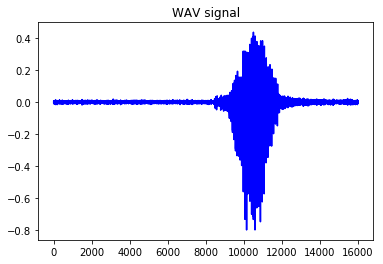

In [3]:
index = 2345
print("File: " + train[index] + " - Label: " + str(trainLabels[index]))

# Plot a wav
file_name = train[index]
wav = dg.DataGeneration.load_data(dataset_dir, file_name)

plt.figure()
plt.plot(wav, color='b')
plt.title('WAV signal')

Example of preprocessing (extraction of the log mel filterbanks

(100, 80)


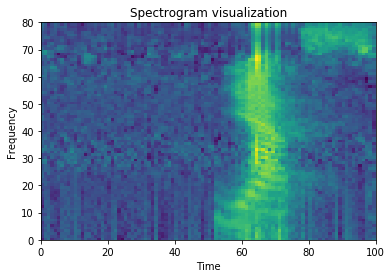

In [4]:
feats = dg.DataGeneration.load_and_preprocess_data(dataset_dir, train[index], False)
print(feats.shape)
feats = np.transpose(feats)
plt.figure()
plt.pcolormesh(feats)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()
#print(feats)

Creation of the datasets for the training part

In [5]:
batch_size = 128

train_dataset = dg.DataGeneration.create_dataset(dataset_dir, train, trainLabels, 
                                                 batch_size = batch_size, 
                                                 shuffle = True, 
                                                 cache_file = 'train_cache_Attention_35class')

val_dataset = dg.DataGeneration.create_dataset(dataset_dir, val, valLabels, 
                                               batch_size = batch_size, 
                                               shuffle = False, 
                                               cache_file = 'val_cache_Attention_35class')

test_dataset = dg.DataGeneration.create_dataset(dataset_dir, test, testLabels, 
                                                batch_size = batch_size, 
                                                shuffle = False, 
                                                cache_file = 'test_cache_Attention_35class')

train_steps = int(np.ceil(len(train) / batch_size))
val_steps = int(np.ceil(len(val) / batch_size))
test_steps = int(np.ceil(len(test) / batch_size))

print("steps to completa a train epoch: " + str(train_steps))
print("steps to completa a validation spoch: " + str(val_steps))
print("steps to completa a test epoch: " + str(test_steps))

steps to completa a train epoch: 663
steps to completa a validation spoch: 78
steps to completa a test epoch: 86


# CNN model (from the paper)

Lost the weights configurations

In [ ]:
model = Model.CNN(nCategs, 100, 80, activation = 'relu')
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/CNN-checkpoint.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001

adam = tf.train.AdamOptimizer(learning_rate, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = adam,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

model.load_weights('Model/CNN-checkpoint.h5')
#result: train - val - test 

In [ ]:
num_epochs = 1
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

In [ ]:
#model.save_weights('Model/CNN-e---weights.h5')
#model.save('Model/CNN-e---.h5')

In [ ]:
res = model.evaluate(test_dataset, steps = test_steps)

index = 111
x_in = dg.DataGeneration.load_and_preprocess_data(dataset_dir, test[index], False).reshape((1, 100, 80, 1))
sol = model.predict(x_in)
print(sol*100)
print(test[index] + " - Label: " + str(testLabels[index]))
print("Predict: " + str(np.argmax(sol)))

# 1 RNN + Attention (with final state) 

In [ ]:
model = Model.RNNAtt(nCategs, 100, 80, 64, use_GRU = True, dropout = 0.0, activation = 'relu')
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/RNNAtt-checkpoint.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001

adam = tf.train.AdamOptimizer(learning_rate, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = adam,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

model.load_weights('Model/RNNAtt-checkpoint.h5')
#epoca 1: 

In [ ]:
num_epochs = 1
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])
#final result: train 71.68 - val 67.38

In [ ]:
#model.save_weights('Model/RNNAtt-e---weights.h5')
#model.save('Model/RNNAtt-e---.h5')

In [ ]:
res = model.evaluate(test_dataset, steps = test_steps)

index = 111
x_in = dg.DataGeneration.load_and_preprocess_data(dataset_dir, test[index], False).reshape((1, 100, 80, 1))
sol = model.predict(x_in)
print(sol*100)
print(test[index] + " - Label: " + str(testLabels[index]))
print("Predict: " + str(np.argmax(sol)))

# Douglas Network 

In [ ]:
model = Model.AttRNNSpeechModel(nCategs)
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/AttRNNSpeechModel-checkpoint.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001

adam = tf.train.AdamOptimizer(learning_rate, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = adam,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

model.load_weights('Model/AttRNNSpeechModel-e10-95-93-weights.h5')
#epoca 1: train 62.25 - val 85.08 
#epoca 2: train 86.93 - val 88.17
#epoca 3: train 90.06 - val 90.67 
#epoca 4: train 91.45 - val 90.65
#epoca 5: train 94.39 - val 92.78 
#epoca 6: train 95.03 - val 92.97 (riduco il learning rate da 0.001 a 0.0001)
#epoca 7: train 95.42 - val 92.97 
#epoca 8: train 95.82 - val 93.08 (ridotto learning rate da 0.0001 a 0.00005)
#epoca 9: train 96.01 - val 93.11 
#epoca10: train 96.30 - val 93.11 - test 92.71 (ridotto learning rate da 0.00005 a 0.00001) <--- STOP TRAINING 

In [ ]:
num_epochs = 1
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

In [ ]:
#model.save_weights('Model/AttRNNSpeechModel-e10-95-93-weights.h5')
#model.save('Model/AttRNNSpeechModel-e10-95-93.h5')

In [ ]:
res = model.evaluate(test_dataset, steps = test_steps)

index = 111
x_in = dg.DataGeneration.load_and_preprocess_data(dataset_dir, test[index], False).reshape((1, 100, 80, 1))
sol = model.predict(x_in)
#print(sol*100)
print(test[index] + " - Label: " + str(testLabels[index]))
print("Predict: " + str(np.argmax(sol)))

# CNN (no paper) + 2 RNN (passing the state) + Attention (with final state) 

In [ ]:
model = Model.CNNRNNAttState(nCategs, 100, 80, 64, use_GRU = True, dropout = 0.0, activation = 'relu')
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/CNNRNNAttState-checkpoint.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001

adam = tf.train.AdamOptimizer(learning_rate, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = adam,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

model.load_weights('Model/CNNRNNAttState-e13-93-93-weights.h5')
#epoca 1: train 21 - val 53 
#epoca 2: train 55 - val 73
#epoca 3: train 68 - val 80
#epoca 4: train 79 - val 86
#epoca 5: train 83 - val 88.9
#epoca 6: train 85.6 - val 90.3
#epoca 7: train 86.9 - val 91
#epoca 8: train 90.41 - val 92.68 - test 91.85 (ridotto drop da 0.1 a 0.05, learning da 0.001 a 0.0001)
#epoca 9: train 91.15 - val 92.98
#epoca10: train 92.43 - val 93.15 - test 92.51 (ridotto drop da 0.05 a 0.0, learning rate ridotto da 0.0001 a 0.00001)
#epoca11: train 93.02 - val 93.07              (drop di alcuni layer passato da 0.1 a 0.05) (non salito validation)
#epoca12: train 93.09 - val 93.11              (abbassato learning rate da 0.00001 a 0.000001)
#epoca13: train 93.12 - val 93.13 - test 92.55 (rimosso la regolarizzazzione l2) <--- STOP TRAINING

In [ ]:
num_epochs = 1
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

In [ ]:
#model.save_weights('Model/CNNRNNAttState-e---weights.h5')
#model.save('Model/CNNRNNAttState-e---.h5')

In [ ]:
res = model.evaluate(test_dataset, steps = test_steps)

index = 111
x_in = dg.DataGeneration.load_and_preprocess_data(dataset_dir, test[index], False).reshape((1, 100, 80, 1))
sol = model.predict(x_in)
#print(sol*100)
print(test[index] + " - Label: " + str(testLabels[index]))
print("Predict: " + str(np.argmax(sol)))

# CNN (no paper) + 2 RNN (passing the state) + Attention (Douglas) 

In [ ]:
model = Model.CNNRNNAttDouglas(nCategs, 100, 80, 64, use_GRU = True, dropout = 0.0, activation = 'relu')
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/CNNRNNAttDouglas-checkpoint.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001

adam = tf.train.AdamOptimizer(learning_rate, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = adam,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

model.load_weights('Model/CNNRNNAttDouglas-checkpoint.h5')
#epoca 1: train 56 - val 79 (drop 0, alcuni drop a 0.1, unita 64, learning_rate 0.001)
#epoca 2: train 83 - val 89 
#epoca 3: train 89 - val 91
#epoca 4: train 89 - val 91.1 
#epoca 5: train 91.68 - val 92.76               (abbassato il learning rate da 0.001 a 0.0001)
#epoca 6: train 92.28 - val 93.13 
#epoca 7: train 92.47 - val 93.17
#epoca 8: train 92.83 - val 93.46               (ridotto learning rate da 0.0001 a 0.00001)
#epoca 9: train 92.84 - val 93.44 
#epoca10: train 92.94 - val 93.47 - test 92.62  (ridotto learning rate da 0.00001 a 0.000001) <-- STOP TRAINING

In [ ]:
num_epochs = 1
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

In [ ]:
#model.save_weights('Model/CNNRNNAttDouglas-e---weights.h5')
#model.save('Model/CNNRNNAttDouglas-e---.h5')

In [ ]:
res = model.evaluate(test_dataset, steps = test_steps)

index = 111
x_in = dg.DataGeneration.load_and_preprocess_data(dataset_dir, test[index], False).reshape((1, 100, 80, 1))
sol = model.predict(x_in)
#print(sol*100)
print(test[index] + " - Label: " + str(testLabels[index]))
print("Predict: " + str(np.argmax(sol)))

# CNN (no paper) + 2 RNN (no state) + Attention (Douglas) 

In [ ]:
model = Model.CNNRNNStatefulAttDouglas(nCategs, 100, 80, 64, use_GRU = True, dropout = 0.0, activation = 'relu')
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/CNNRNNStatefulAttDouglas-checkpoint.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001

adam = tf.train.AdamOptimizer(learning_rate, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = adam,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

model.load_weights('Model/CNNRNNStatefulAttDouglas-checkpoint.h5')
#epoca 1: train 35.80 - val 68.91
#epoca 2: train 76.35 - val 84.83
#epoca 3: train 84.64 - val 88.85
#epoca 4: train 88.81 - val 91.09
#epoca 5: train 89.85 - val 90.51 <-- No contata
#epoca 6: train 91.48 - val 92.57 (ridotto il learning rate da 0.001 a 0.0001)
#epoca 7: train 92.04 - val 92.68 
#epoca 8: train 92.27 - val 92.75 
#epoca 9: train 92.47 - val 92.99 (ridotto learning rate da 0.0001 a 0.00001)
#epoca10: train 92.95 - val 93.04 - test 92.54 (ridotto il learning rate da 0.00001 a 0.000005)
#epoca11: train 92.94 - val 92.92 <-- STOP modello da tenere epoca 10

In [ ]:
num_epochs = 1
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

In [ ]:
#model.save_weights('Model/CNNRNNStatefulAttDouglas-e---weights.h5')
#model.save('Model/CNNRNNStatefulAttDouglas-e---.h5')

In [ ]:
res = model.evaluate(test_dataset, steps = test_steps)

index = 111
x_in = dg.DataGeneration.load_and_preprocess_data(dataset_dir, test[index], False).reshape((1, 100, 80, 1))
sol = model.predict(x_in)
print(sol*100)
print(test[index] + " - Label: " + str(testLabels[index]))
print("Predict: " + str(np.argmax(sol)))

# CNN (paper) + 2 RNN (no state) + Attention (Douglas) 

Lost the weights configurstions

In [ ]:
model = Model.PCNNRNNStatefulAttDouglas(nCategs, 100, 80, 32, use_GRU = True, dropout = 0.0, activation = 'relu')
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/PCNNRNNStatefulAttDouglas-checkpoint.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001

adam = tf.train.AdamOptimizer(learning_rate, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = adam,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

model.load_weights('Model/PCNNRNNStatefulAttDouglas-final.h5')
#result: validation: 88.26%

In [ ]:
num_epochs = 1
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

In [ ]:
#model.save_weights('Model/PCNNRNNStatefulAttDouglas-e---weights.h5')
#model.save('Model/PCNNRNNStatefulAttDouglas-e---.h5')

In [ ]:
res = model.evaluate(test_dataset, steps = test_steps)

index = 111
x_in = dg.DataGeneration.load_and_preprocess_data(dataset_dir, test[index], False).reshape((1, 100, 80, 1))
sol = model.predict(x_in)
print(sol*100)
print(test[index] + " - Label: " + str(testLabels[index]))
print("Predict: " + str(np.argmax(sol)))

# CNN (no paper) + 2 RNN (passing the state) + MultyAttention   

In [ ]:
model = Model.MultyAttention(nCategs, 100, 80, 64, use_GRU = True, dropout = 0.0, activation = 'relu')
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/MultyAttention-checkpoint.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001

adam = tf.train.AdamOptimizer(learning_rate, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = adam,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

model.load_weights('Model/MultyAtt-e13-92-94-weights.h5')
#epoca 1: train 28.04 - val 64.88 (unita 64, multi attention con centrale e stato finale, drop 0.2, alcuni drop a 0.05, altri a 0.1, l2 a 0)
#epoca 2: train 66.04 - val 82.39
#epoca 3: train 76.31 - val 86.80
#epoca 4: train 84.36 - val 88.96 (drop da 0.2 a 0.1)
#epoca 5: train 89.18 - val 90.97 (drop da 0.1 a 0.05, altri drop da 0.1  a 0.0)
#epoca 6: train 90.62 - val 92.04
#epoca 7: train 92.53 - val 93.28 (drop da 0.05 a 0.0, learning rate da 0.001 a 0.0005)
#epoca 8: train 93.38 - val 92.94 (un po di overfitting)
#epoca 9: train 93.96 - val 93.23 (ridotto learning rata da 0.0005 a 0.00005)
#epoca10: train 94.49 - val 93.13 (ridotto learning rate da 0.00005 a 0.00001)
#epoca11: train 94.94 - val 93.01 (ridotto learning rate da 0.00001 a 0.000001)
#epoca12: train 92.63 - val 93.62 (rimetto un po di drop out a 0.1)
#epoca13: train 92.83 - val 94.02 - test 93.11
#epoca14: train 93.08 - val 93.98 (ridotto learning rate da 0.000001 a 0.0000005)
#epoca15: train 93.21 - val 93.86 (ridotto learning rate da 0.0000005 a 0.0000001) <--- STOP LEARNING BEST MODEL EPOCA 13

In [ ]:
num_epochs = 1
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

In [ ]:
#model.save_weights('Model/MultyAttention-e---weights.h5')
#model.save('Model/MultyAttention-e---.h5')

In [ ]:
res = model.evaluate(test_dataset, steps = test_steps)

index = 111
x_in = dg.DataGeneration.load_and_preprocess_data(dataset_dir, test[index], False).reshape((1, 100, 80, 1))
sol = model.predict(x_in)
print(sol*100)
print(test[index] + " - Label: " + str(testLabels[index]))
print("Predict: " + str(np.argmax(sol)))

# CNN (Douglas) + 2 RNN (no passing the state) + MultyAttention   

In [ ]:
model = Model.MultyAttentionDouglas(nCategs, 100, 80, dropout = 0.0)
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/MultyAttentionDouglas-checkpoint.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001

adam = tf.train.AdamOptimizer(learning_rate, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = adam,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

model.load_weights('Model/MultyAttentionDouglas-e8-95-93-weights.h5')
#epoca 1: train 61.25 - val 83.86 (start: drop 0.1 e learning rate a 0.001)
#epoca 2: train 83.72 - val 88.61 
#epoca 3: train 87.55 - val 90.52
#train 4: train 89.74 - val 90.53 
#epoca 5: train 92.55 - val 92.08 (ridotto learning rate da 0.001 a 0.0005, drop diminuito da 0.1 a 0.05)
#epoca 6: train 93.50 - val 92.62 
#epoca 7: train 95.07 - val 93.04 (ridotto lr da 0.0005 a 0.0001)
#epoca 8: train 95.38 - val 93.34 
#epoca 9: train 96.42 - val 93.22 - test 92.50 (ridtto learning rate da 0.0001 a 0.00001, drop da 0.05 a 0.0) <--STOP LEARNING BEST EPOCA 8

In [ ]:
num_epochs = 1
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

In [ ]:
#model.save_weights('Model/MultyAttentionDouglas-e---weights.h5')
#model.save('Model/MultyAttentionDouglas-e---.h5')

In [ ]:
res = model.evaluate(test_dataset, steps = test_steps)

index = 111
x_in = dg.DataGeneration.load_and_preprocess_data(dataset_dir, test[index], False).reshape((1, 100, 80, 1))
sol = model.predict(x_in)
#print(sol*100)
print(test[index] + " - Label: " + str(testLabels[index]))
print("Predict: " + str(np.argmax(sol)))

# CNN (no paper) + 2 RNN (no state) + MultyAttention with Diff   

In [6]:
model = Model.NewAttentionModelOurs(nCategs, 100, 80, 64, dropout = 0.0, activation = 'relu')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 80, 4)   200         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 80, 4)   16          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 100, 80, 4)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/MultyAttentionDiff-checkpoint.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [8]:
learning_rate = 0.001

adam = tf.train.AdamOptimizer(learning_rate, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = adam,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

model.load_weights('Model/MultyAttentionDiff-final.h5')
# First Epoch: 72% train, 88% validation
# Second Epoch: 88% abbondante train, 90% val
# Third 91.68% train, 90.51% val
# Fourth 92.27% train, 92.57% val
# changing learning rate to 0.0001
# Fifth: 95.25% train, 94,81% val
# Sixth: 95.96% train, 94.93% val
# Seventh: 96.22% train, 94.94% val, test: 94.00%  
# changing learning rate to 0.00005
# Eigth: 96.664% train, 95.07% val, test 
# changing learning rate to 0.00001
# Nineth: 0.9696 train, 0.95.05% val, 

In [ ]:
num_epochs = 1
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

In [ ]:
#model.save_weights('Model/MultyAttentionDiff-e---weights.h5')
#model.save('Model/MultyAttentionDiff-e---.h5')

In [ ]:
res = model.evaluate(test_dataset, steps = test_steps)

index = 111
x_in = dg.DataGeneration.load_and_preprocess_data(dataset_dir, test[index], False).reshape((1, 100, 80, 1))
sol = model.predict(x_in)
#print(sol*100)
print(test[index] + " - Label: " + str(testLabels[index]))
print("Predict: " + str(np.argmax(sol)))

# Some plots 

## Confusion matrix 

86/86 [==============================] - 94s 1s/step
Normalized confusion matrix


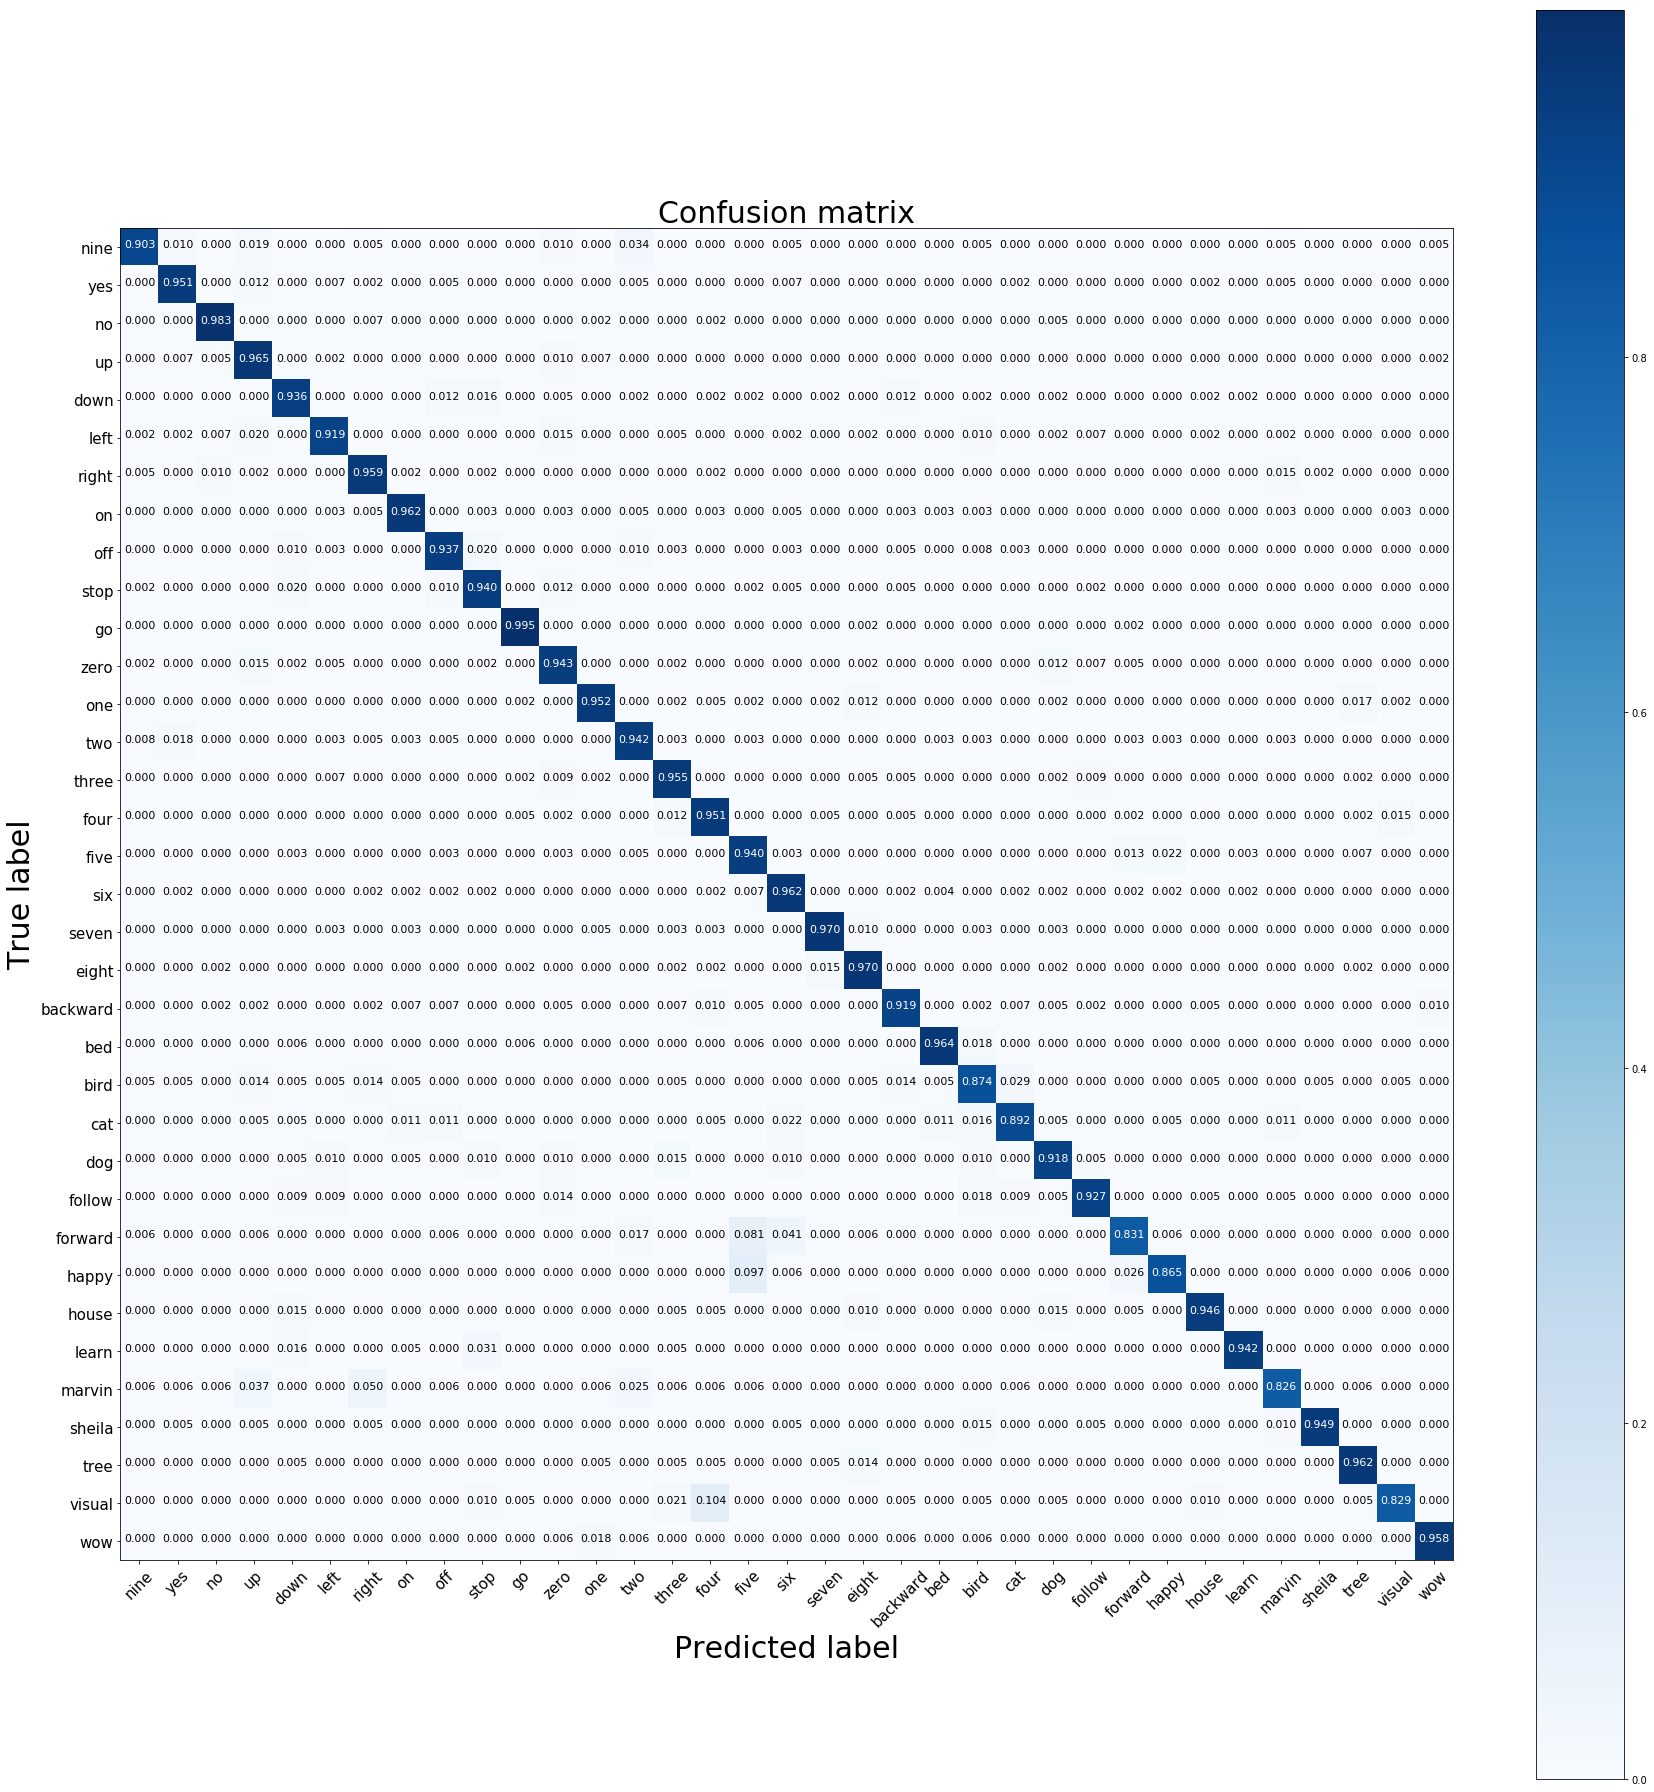

In [9]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_dataset, steps = test_steps, verbose = 1)

classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 'one', 'two', 'three', 
           'four', 'five', 'six', 'seven', 'eight', 'backward', 'bed', 'bird', 'cat', 'dog', 'follow', 'forward', 'happy',
           'house', 'learn', 'marvin', 'sheila', 'tree', 'visual', 'wow']

cm = confusion_matrix(testLabels, np.argmax(y_pred[0:11005], 1))

dg.DataGeneration.plot_confusion_matrix(cm,classes, normalize=True, filename="Images/MultyAttentionDiffConfusionMatrix.png")

## Attention Weights

In [10]:
plotModel = tf.keras.Model(inputs=model.input, outputs=[model.get_layer('output').output,
                                                        #model.get_layer('attSoftmax').output, # only for singol attention
                                                        model.get_layer('attSoftmaxFirst').output, # only for multy attention models 
                                                        model.get_layer('attSoftmaxSecond').output, # only for multy attention models
                                                        model.get_layer('squeeze_last_dim').output])

three/1b4c9b89_nohash_1.wav.npy


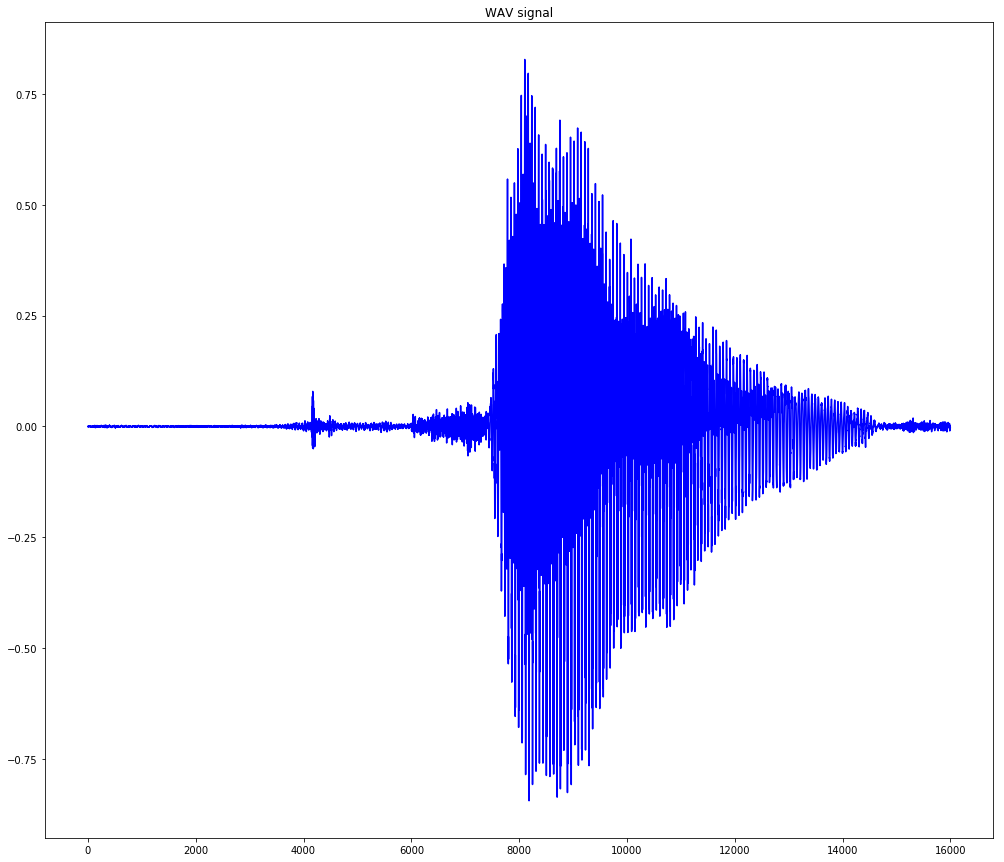

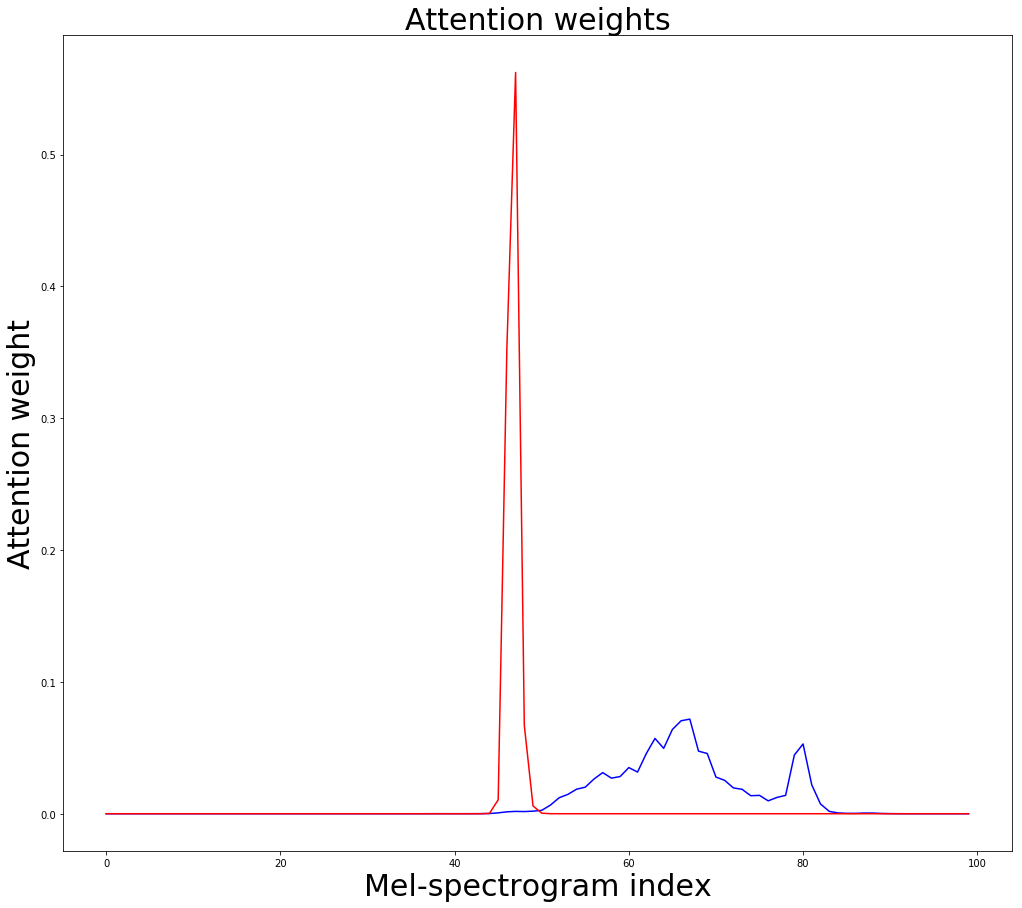

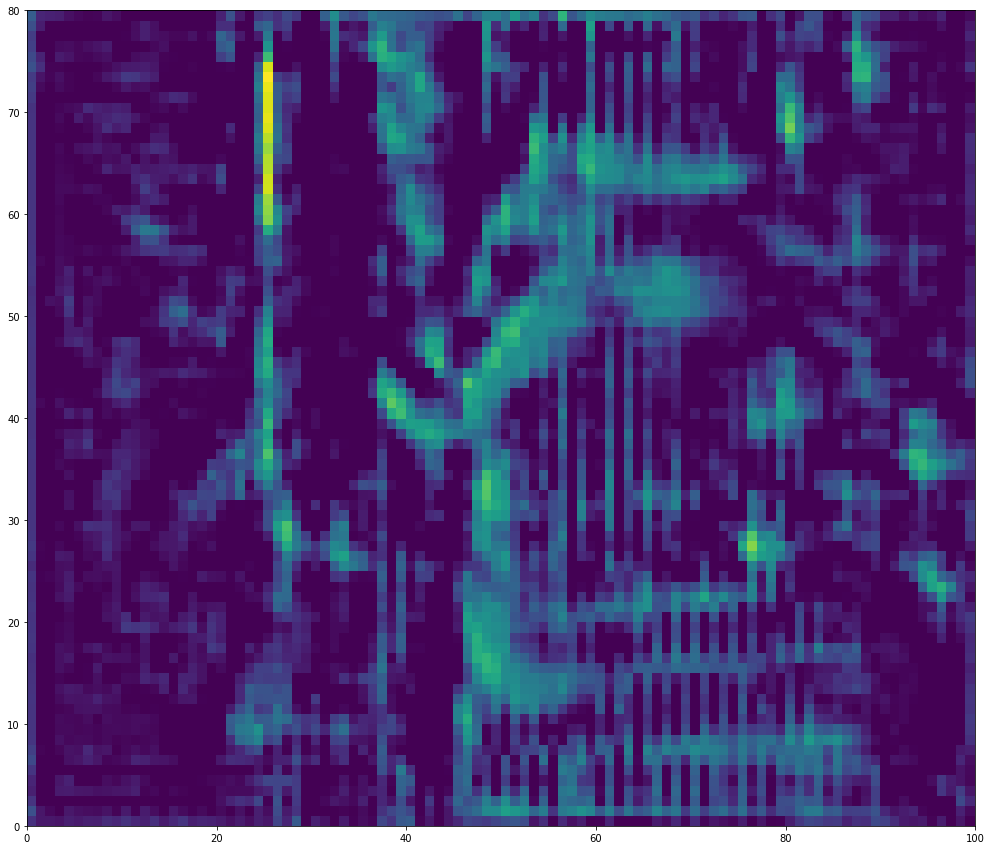

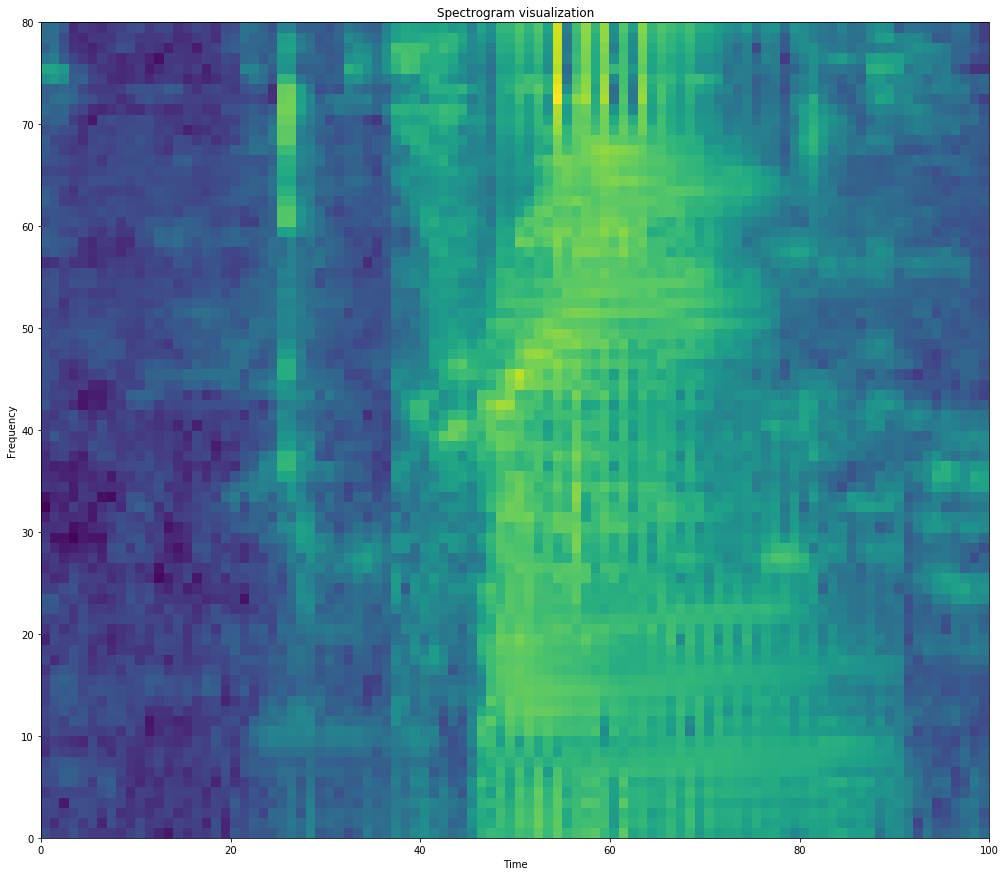

In [12]:
index = 4852
print(test[index])
x_in = dg.DataGeneration.load_and_preprocess_data(dataset_dir, test[index], False).reshape((1, 100, 80, 1))
outs, attW1, attW2, feature = plotModel.predict(x_in) #only for multy attention models
#outs, attW1, feature = plotModel.predict(x_in)

# Plot a wav
wav = dg.DataGeneration.load_data(dataset_dir, test[index])

plt.figure(figsize=(17,15))
plt.plot(wav, color='b')
plt.savefig('Images/picWAV.png', dpi = 400)
plt.title('WAV signal')

#print(attW.shape)
plt.figure(figsize=(17, 15))
plt.title('Attention weights', fontsize=30)
plt.ylabel('Attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
#plt.plot(np.log(attW[0, :]+1e-8))
plt.plot(attW1[0, :], 'b')
plt.plot(attW2[0, :], 'r') # only for multy attention models
#plt.plot(attW1[0, :] - attW2[0, :], 'g') #only for diff attention
plt.savefig('Images/MultyAttentionDiffAttentionWeights.png', dpi = 400)
plt.show()

feature = np.transpose(feature.reshape((100, 80)))
plt.figure(figsize=(17,15))
plt.pcolormesh(feature)
plt.savefig('Images/MultyAttentionDiffFeaturesExtracted.png', dpi = 400)

feats = dg.DataGeneration.load_and_preprocess_data(dataset_dir, test[index], False)
feats = np.transpose(feats)
plt.figure(figsize=(17,15))
plt.pcolormesh(feats)
plt.savefig('Images/picInput.png', dpi = 400)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()